In [1]:
# dowaload the packge if needed
! pip install pandas numpy matplotlib statsmodels


  Using cached statsmodels-0.14.4-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.15.3-cp313-cp313-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 6.7 MB/s eta 0:00:00a 0:00:01
Using cached statsmodels-0.14.4-cp313-cp313-macosx_11_0_arm64.whl (9.9 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached scipy-1.15.3-cp313-cp313-macosx_14_0_arm64.whl (22.4 MB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [statsmodels] [statsmodels]


In [1]:
# session level paramater analyse
# 这个是final的。 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

female_color = '#D55672'
male_color = '#0075A2'
femaleIDs = {'rat150','rat152','rat224','rat225','rat228'}

def add_sex(df):
    return df.assign(sex=df['ratID'].apply(lambda r: 'female' if r in femaleIDs else 'male'))

def fit_lme_nested(df, param_name):
    df = df.dropna(subset=[param_name]).copy()
    df["rat_section"] = df["ratID"] + "_" + df["sectionID"].astype(str)
    model = smf.mixedlm(f"{param_name} ~ sex", df, groups=df["ratID"],
                        vc_formula={"rat_section": "0 + C(rat_section)"})
    result = model.fit(reml=False)
    coef = result.params.get("sex[T.male]", np.nan)
    p_val = result.pvalues.get("sex[T.male]", np.nan)
    return coef, p_val


def plot_param_lme_nested(df, param_name, ylabel, title, use_abs=False):
    if use_abs:
        df[param_name] = df[param_name].abs()

    is_male = df["sex"] == "male"
    is_female = df["sex"] == "female"
    male_vals = df.loc[is_male, param_name].values
    female_vals = df.loc[is_female, param_name].values

    
    coef, p_val = fit_lme_nested(df, param_name)
    print(f"[{param_name}] LME p = {p_val:.4f}")

    fig, ax = plt.subplots(figsize=(2, 2), dpi=400)
    groups = [male_vals, female_vals]
    bp = ax.boxplot(groups, patch_artist=True, widths=0.5, showfliers=False,
                    boxprops=dict(facecolor='white', linewidth=1.5),
                    medianprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    for i, color in enumerate([male_color, female_color]):
        bp['boxes'][i].set_edgecolor(color)
        bp['whiskers'][2*i].set_color(color)
        bp['whiskers'][2*i+1].set_color(color)
        bp['caps'][2*i].set_color(color)
        bp['caps'][2*i+1].set_color(color)
        bp['medians'][i].set_color(color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Male', 'Female'])
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=10)
    stars = ''
    if not np.isnan(p_val):
        if p_val < 0.001: stars = '***'
        elif p_val < 0.01: stars = '**'
        elif p_val < 0.05: stars = '*'
    if stars:
        ymin, ymax = ax.get_ylim()
        y_star = ymax - 0.15 * (ymax - ymin)
        ax.text(1.5, y_star, stars, ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

def fit_lme_nested(df, param_name):
    df = df.dropna(subset=[param_name]).copy()
    df["rat_section"] = df["ratID"] + "_" + df["sectionID"].astype(str)
    model = smf.mixedlm(f"{param_name} ~ sex", df, groups=df["ratID"],
                        vc_formula={"rat_section": "0 + C(rat_section)"})
    result = model.fit(reml=False)
    coef = result.params.get("sex[T.male]", np.nan)
    p_val = result.pvalues.get("sex[T.male]", np.nan)
    return coef, p_val

def plot_w_4group_lme(df):
    df = df.dropna(subset=['w']).copy()
    df['group'] = df.apply(lambda row: 
        f"{'Male' if row['ratID'] not in femaleIDs else 'Female'}-" + 
        ("Satiety" if row['w'] < 0 else "Reward"), axis=1)

    group_order = ['Male-Reward', 'Female-Reward', 'Male-Satiety', 'Female-Satiety']
    colors = [male_color, female_color, male_color, female_color]

    fig, ax = plt.subplots(figsize=(3, 2), dpi=400)
    group_data = [df[df['group'] == g]['w'].abs() for g in group_order]
    bp = ax.boxplot(group_data, patch_artist=True, widths=0.5, showfliers=False,
                    boxprops=dict(facecolor='white', linewidth=1.5),
                    medianprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    for i in range(4):
        c = colors[i]
        bp['boxes'][i].set_edgecolor(c)
        bp['whiskers'][2*i].set_color(c)
        bp['whiskers'][2*i+1].set_color(c)
        bp['caps'][2*i].set_color(c)
        bp['caps'][2*i+1].set_color(c)
        bp['medians'][i].set_color(c)


    reward_df = df[df['group'].isin(['Male-Reward', 'Female-Reward'])].copy()
    satiety_df = df[df['group'].isin(['Male-Satiety', 'Female-Satiety'])].copy()

    reward_df['w'] = reward_df['w'].abs()
    satiety_df['w'] = satiety_df['w'].abs()

    coef1, p1 = fit_lme_nested(reward_df, 'w')
    coef2, p2 = fit_lme_nested(satiety_df, 'w')

    print(f"[Reward] LME coef: {coef1:.4f}, p = {p1:.4f}")
    print(f"[Satiety] LME coef: {coef2:.4f}, p = {p2:.4f}")

    def get_stars(p):
        if p < 0.001: return '***'
        elif p < 0.01: return '**'
        elif p < 0.05: return '*'
        else: return ''

    star1 = get_stars(p1)
    star2 = get_stars(p2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(range(1, 5))
    ax.set_xticklabels(group_order, rotation=15)
    ax.set_ylabel("|w|")
    ax.set_title("Boundary Modulation w by Sex & Type")

    y_top = ax.get_ylim()[1]
    y_star = y_top * 0.85 

    if star1:
        ax.text(1.5, y_star, star1, ha='center', fontsize=12)
    if star2:
        ax.text(3.5, y_star, star2, ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()



[k] LME p = 0.0000


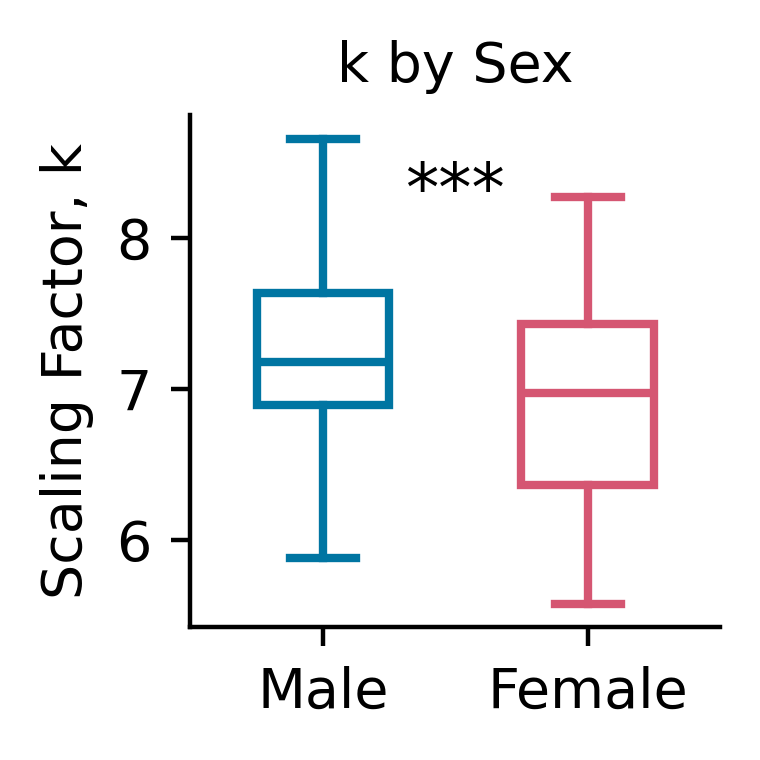

[a] LME p = 0.0000


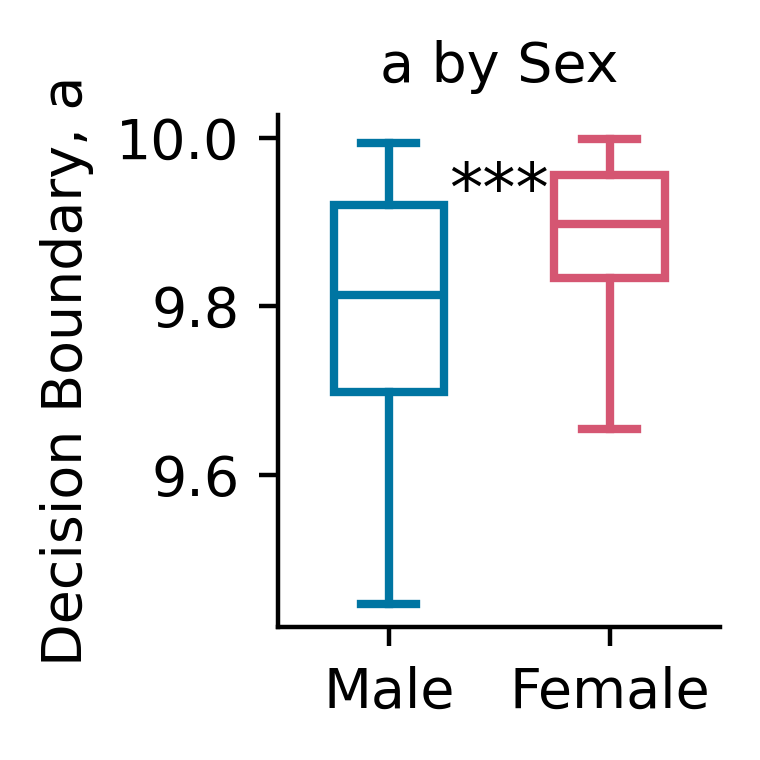

[w] LME p = 0.0000


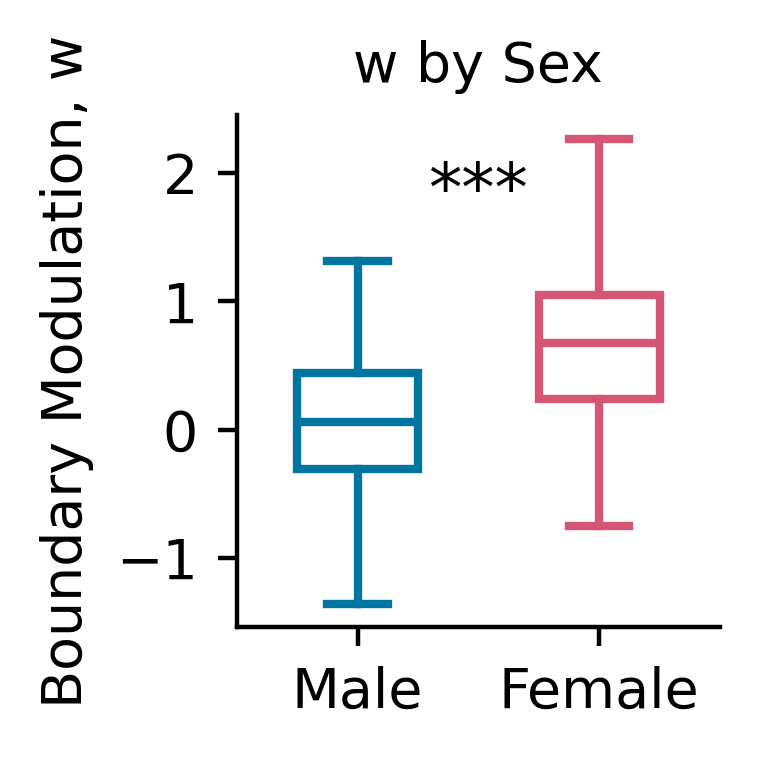

[T] LME p = 0.0000


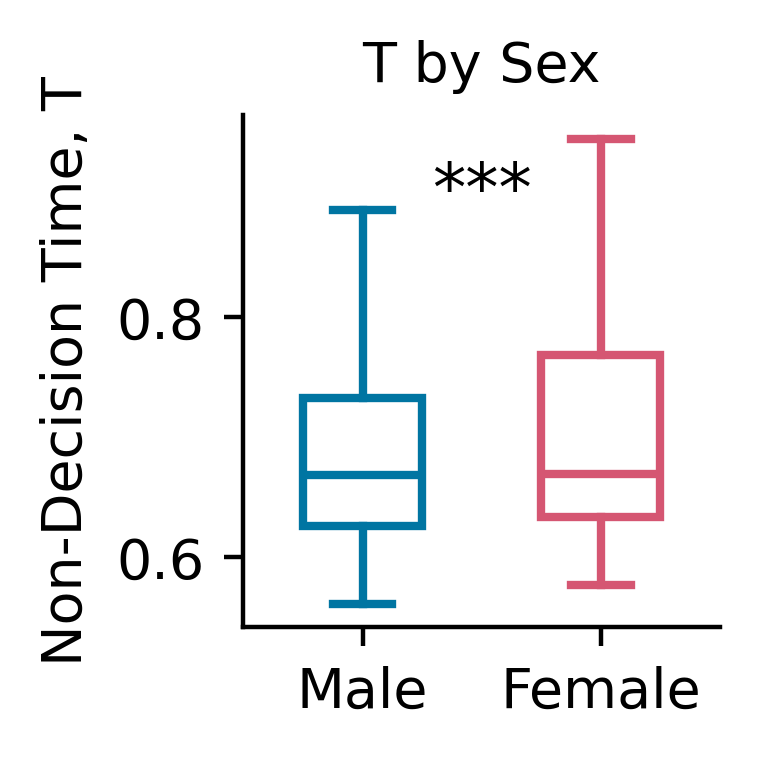

[Reward] LME coef: -0.4094, p = 0.0000
[Satiety] LME coef: -0.3714, p = 0.0006


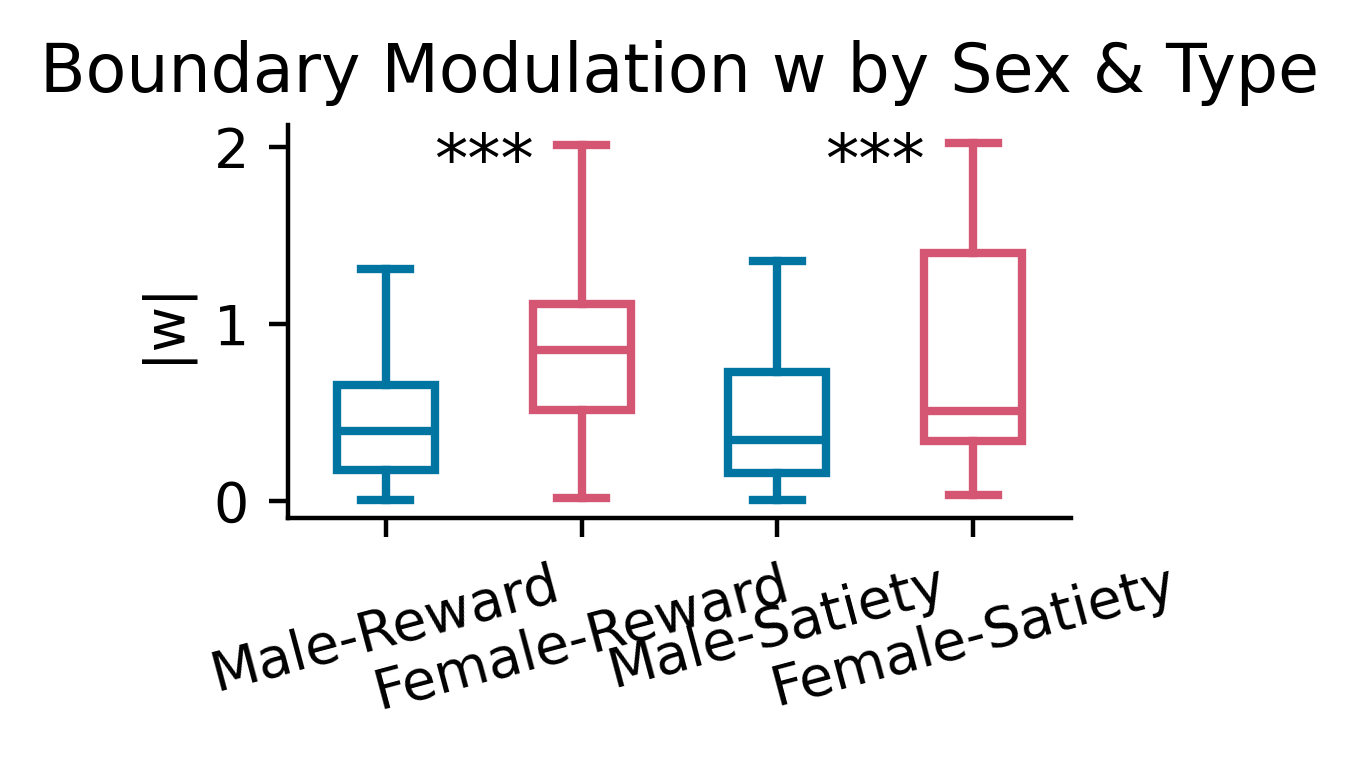

In [4]:
CSV_PATH = 'init.csv'

if __name__ == "__main__":
    df = pd.read_csv(CSV_PATH)
    df = add_sex(df)

    plot_param_lme_nested(df, 'k', 'Scaling Factor, k', 'k by Sex', use_abs=False)
    plot_param_lme_nested(df, 'a', 'Decision Boundary, a', 'a by Sex', use_abs=False)
    plot_param_lme_nested(df, 'w', 'Boundary Modulation, w', 'w by Sex', use_abs=False)
    plot_param_lme_nested(df, 'T', 'Non-Decision Time, T', 'T by Sex', use_abs=False)
    plot_w_4group_lme(df)

[k] LME p = 0.0000


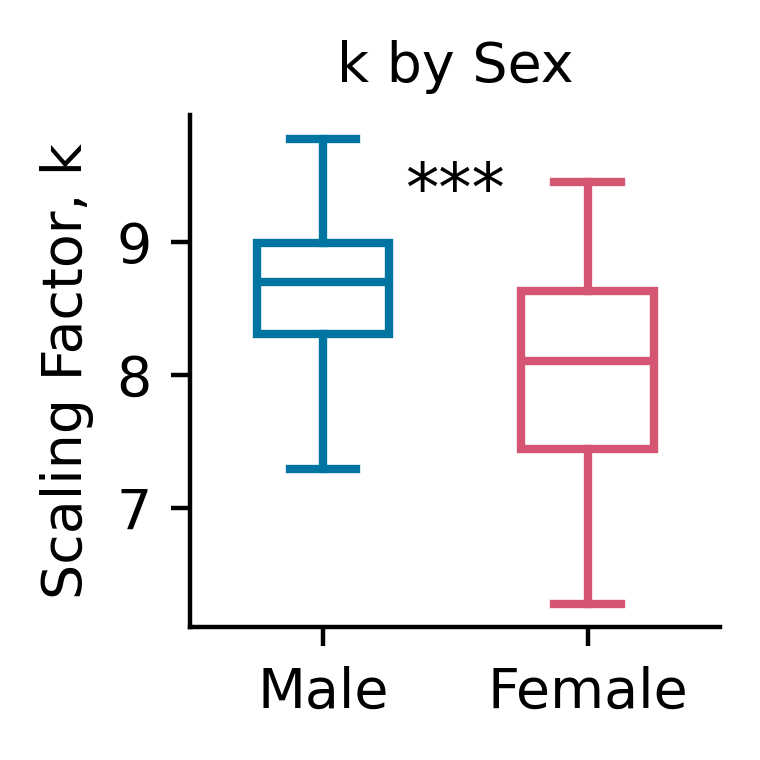

[a] LME p = 0.0000


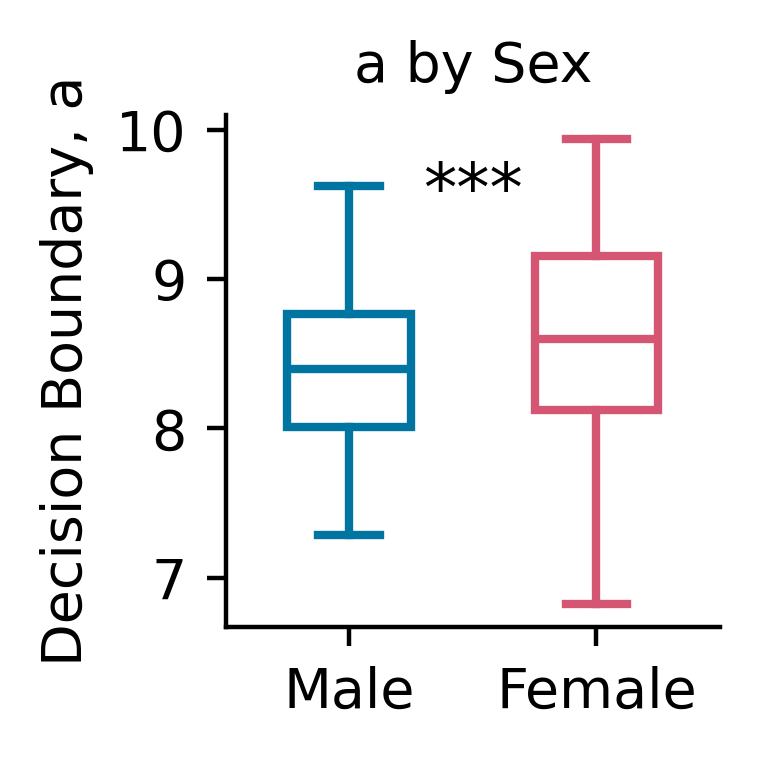

[w] LME p = 0.7894


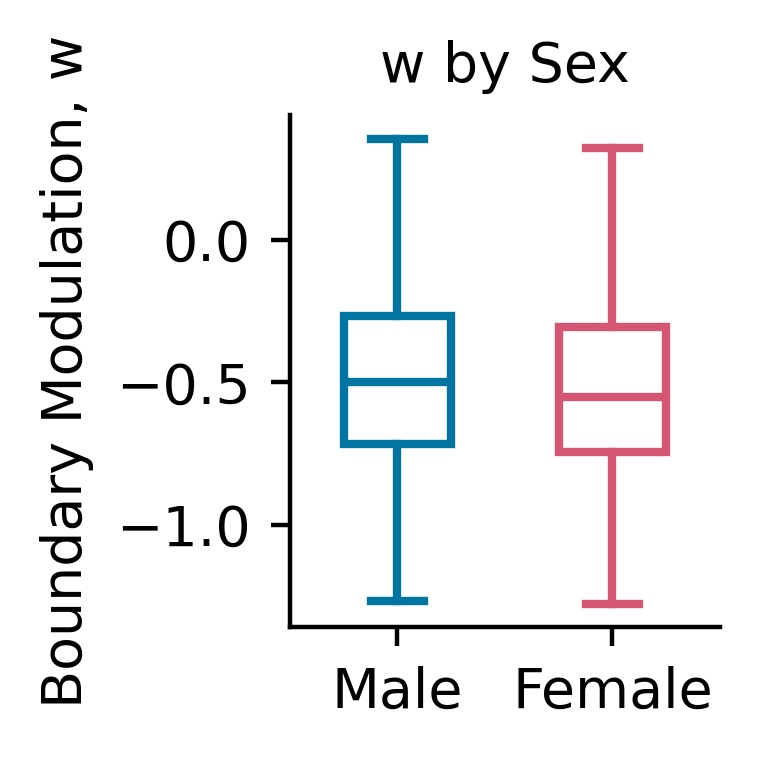

[T] LME p = 0.0000


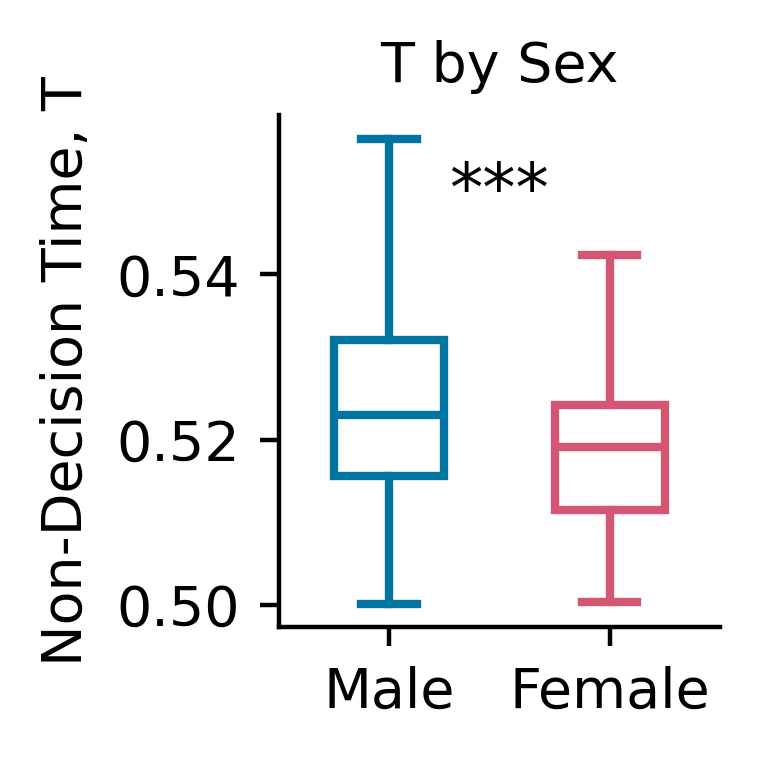

[Reward] LME coef: -0.2902, p = 0.0084
[Satiety] LME coef: -0.0871, p = 0.0078


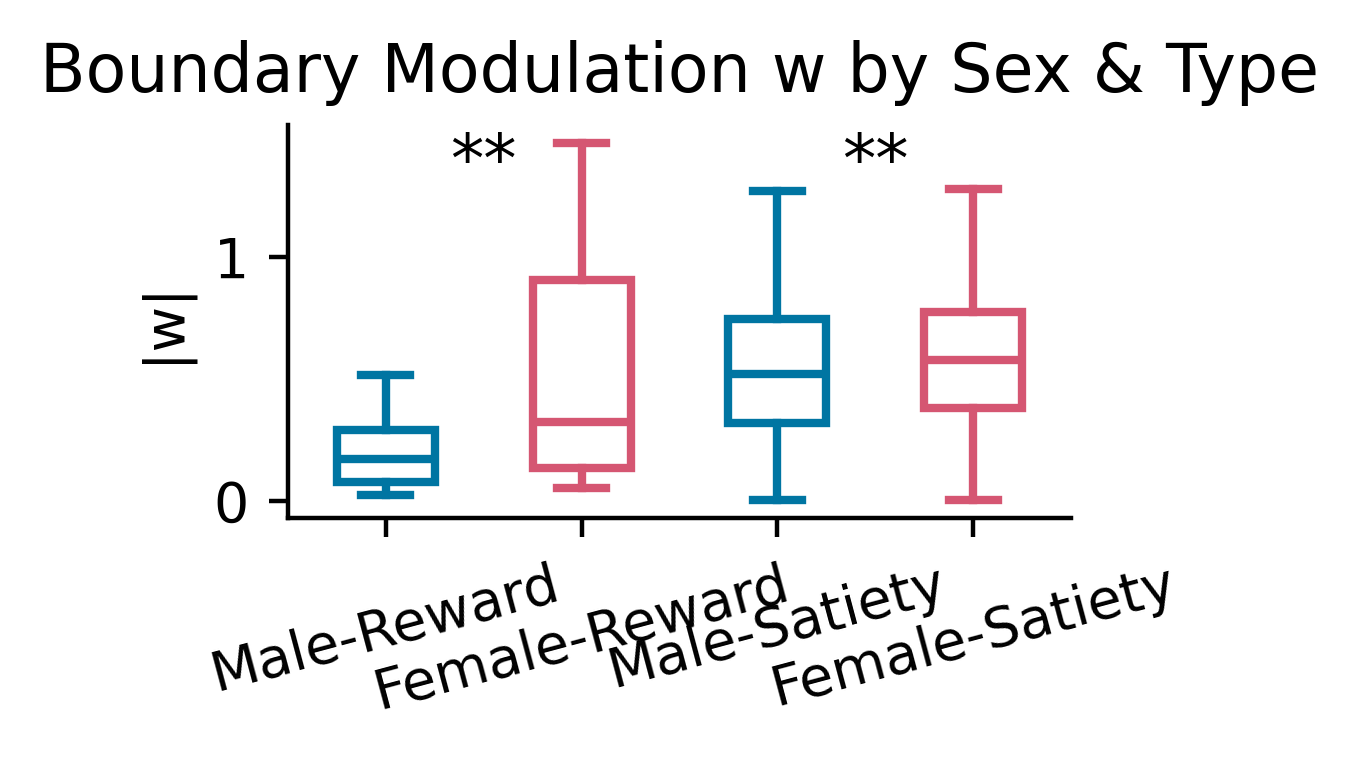

In [5]:
CSV_PATH = 'choice.csv'

if __name__ == "__main__":
    df = pd.read_csv(CSV_PATH)
    df = add_sex(df)

    plot_param_lme_nested(df, 'k', 'Scaling Factor, k', 'k by Sex', use_abs=False)
    plot_param_lme_nested(df, 'a', 'Decision Boundary, a', 'a by Sex', use_abs=False)
    plot_param_lme_nested(df, 'w', 'Boundary Modulation, w', 'w by Sex', use_abs=False)
    plot_param_lme_nested(df, 'T', 'Non-Decision Time, T', 'T by Sex', use_abs=False)
    plot_w_4group_lme(df)